In [199]:
# Get the data
import numpy as np
import pickle

path = 'C://Users/ewmal/PycharmProjects/pyimages/linescan_dz_tuples.pkl'

combined = pickle.load(open(path, 'rb'))
linescans, dz = zip(*combined)

In [391]:
# Preprocess
import sklearn.preprocessing as pre
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

x = np.array(linescans)
y = np.array(dz).reshape(-1, 1)  # sklearn likes 1d better than column vector

# remove bad data (dz < -1)
good_ixs = np.where(y > -1)[0]
x = x[[good_ixs]]
y = y[[good_ixs]]
print('Removed %s datapoints < -1' % (len(dz)-len(y.flatten())))
print('New y shape: ', y.shape)

# normalize
x = pre.normalize(x, axis=1)  # don't try normalizing y, destroys accuracy
x = np.subtract(x, np.mean(x, axis=0))  # center mean of x on 0 (y is already centered)
# y = pre.normalize(y, axis=1)

# try pca (has basically the same performance, slightly worse <.2, better <.3)
pca = PCA(n_components=9)  # 9 works best empirically
x = pca.fit_transform(x)
print('New x shape: ', x.shape)


"""
# plot linescans and x for visual comparison
plt.plot(range(linescans.shape[1]), linescans[0])
plt.show()
plt.plot(range(x.shape[1]), x[0])  # <<< obsolete if pca decomposition
plt.show()
"""


Removed 2098 datapoints < -1
New y shape:  (3982, 1)


New x shape:  (3982, 9)


'\n# plot linescans and x for visual comparison\nplt.plot(range(linescans.shape[1]), linescans[0])\nplt.show()\nplt.plot(range(x.shape[1]), x[0])  # <<< obsolete if pca decomposition\nplt.show()\n'

In [392]:
# SVR
from sklearn.svm import SVR


def svr():
    # train/test split
    split = int(y.shape[0] * 0.8)
    x_train, x_test = x[:split], x[split:]
    y_train, y_test = y[:split], y[split:]
    
    # fit SVM
    svrm = SVR(kernel='rbf', C=5e4, gamma=0.02)  # best: C=5e3,gamma=0.14/C=5e4, gamma=0.02
    svr_fit = svrm.fit(x_train, y_train.flatten())
    
    # make predictions on train and test sets
    y_fitted = svr_fit.predict(x_train)
    y_predicted = svr_fit.predict(x_test)
    print('Done!')
    
    return y_fitted, y_predicted, y_train, y_test


y_fit, y_pred, y_train, y_test = svr()

Done!


R2 train score:  0.972421335992
R2 test score:  0.978973167143
Percent within +/-0.2 error:  0.7365119196988708
Percent within +/-0.25 error:  0.8582183186951067
Percent within +/-0.3 error:  0.9548306148055207


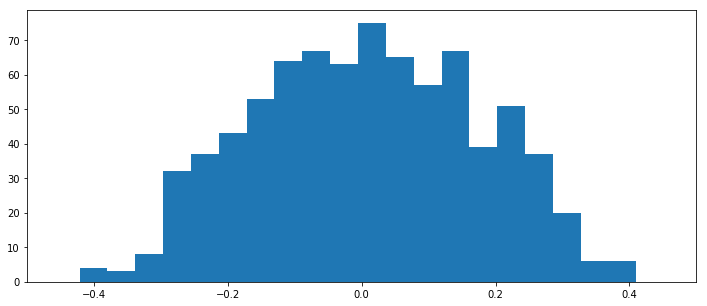

In [393]:
# Evaluation
import matplotlib.pyplot as plt
import sklearn.metrics as met


def r2_evaluate(y_true_train, y_true_test, y_predicted, y_fitted, thresholds=(0.2, 0.25, 0.3)):
    # R**2 score
    fit_score = met.r2_score(y_true=y_true_train, y_pred=y_fitted)
    pred_score = met.r2_score(y_true=y_true_test, y_pred=y_predicted)
    print('R2 train score: ', fit_score)
    print('R2 test score: ', pred_score)
    
    # Histogram
    error = y_true_test.flatten()-y_pred
    for threshold in thresholds:
        low_error_percent = len([err for err in abs(error) if err <= threshold])/len(error)
        print('Percent within +/-%s error: ' % threshold, low_error_percent)
    plt.hist(error, bins=20)
    plt.xlim((-.5, .5))
    plt.show()


r2_evaluate(y_train, y_test, y_pred, y_fit)

Best I was able to get was using pca and svr:
R2 train score:  0.972400535307
R2 test score:  0.979066033186
Percent within +/-0.2 error:  0.7365119196988708
Percent within +/-0.25 error:  0.8582183186951067
Percent within +/-0.3 error:  0.954830614805520
C=5e4,gamma=0.01
normalizing x but not y
n_components = 9 for pca

I'm going to try some deep learning techniques, see below...


In [339]:
import Autoencoder as vae
import tensorflow as tf

y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob)

KeyboardInterrupt: 